In [289]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import pandas as pd
from sklearn import model_selection

# Data Preprocessing

In [227]:
# Load data
DATA_DIR = 'data' # You may change the directory

users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR))
events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR))
subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col=0)

In [228]:
# extract game_name and number_range from the events dataframe to match the subtasks dataframe (given the event_id)
game_name = subtasks.merge(events[['event_id', 'game_name']], on='event_id', how='left').game_name
number_range = subtasks.merge(events[['event_id', 'number_range']], on='event_id', how='left').number_range

#split the game_name into skills
game_in_skill = {'Number representation': ['Subitizing', 'Conversion', 'Estimation', 'Estimation on Number Line', 'Scale: Conversion', 'Landing'], 'Number comparison/manipulation': ['Comparison', 'Secret Number', 'Distance', 'Scale: Composition', 'Order'], 'Addition/Substraction': ['Scale: Decomposition', 'Scale: Subtraction', 'Scale: Subtraction by Tens and Ones', 'Sliderule', 'Plus-minus', 'Difference', 'Completion', 'Calculator'], 'Multiplication/Division': ['Write as multiplication', 'Shelf: Jump Ahead', 'Shelf: given height', 'Shelf: random height', 'Distribution', 'Calculator: Multiplication', 'Calculator: Multiplication with ?', 'Calculator: Division', 'Jump backwards', 'Series']}
skill = game_name.apply(lambda x: 'Number representation' if x in game_in_skill['Number representation'] 
                        else 'Number comparison/manipulation' if x in game_in_skill['Number comparison/manipulation'] 
                        else 'Addition/Substraction' if x in game_in_skill['Addition/Substraction']
                        else 'Multiplication/Division' if x in game_in_skill['Multiplication/Division']
                        else 'Other')
# concatenate skills and number range and add it to the subtasks dataframe
subtasks['skill_name'] = skill + ' ' + number_range

In [229]:
def create_iterator(data):
    '''
    Create an iterator to split interactions in data into train and test, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''    
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0).split(X, groups=groups)

# Data splitting in train, validation and test data
# Obtain indexes
train_index, test_index = next(create_iterator(subtasks))
# Split the data
subtasks_train, subtasks_test = subtasks.iloc[train_index], subtasks.iloc[test_index]

'''
# Split train data in train and validation sets
# Obtain indexes for necessary validation set
train_val_index, val_index = next(create_iterator(subtasks_train))
# Split the training data into training and validation
subtasks_train_val, subtasks_val = subtasks_train.iloc[train_val_index], subtasks_train.iloc[val_index]
'''


'\n# Split train data in train and validation sets\n# Obtain indexes for necessary validation set\ntrain_val_index, val_index = next(create_iterator(subtasks_train))\n# Split the training data into training and validation\nsubtasks_train_val, subtasks_val = subtasks_train.iloc[train_val_index], subtasks_train.iloc[val_index]\n'

# BKT model predictions

In [230]:
from pyBKT.models import Model

In [231]:
# Fit the model
modelBKT = {}
skills = subtasks['skill_name'].unique()
for skill in skills:
    modelBKT[skill] = Model(seed=0, defaults={'order_id' : 'subtask_id'})
    modelBKT[skill].fit(data=subtasks_train[subtasks_train['skill_name'] == skill], forgets = True)

In [232]:
# Make prediction dataset
proba_dataset = {}
proba_test = {}
for skill in skills:
    proba_dataset[skill] = modelBKT[skill].predict(data=subtasks_train[subtasks_train['skill_name'] == skill])[['user_id', 'correct_predictions']]
    proba_test[skill] = modelBKT[skill].predict(data=subtasks_test[subtasks_test['skill_name'] == skill])[['user_id', 'correct_predictions']]
    
    # Add the attempt number
    proba_dataset[skill]['attempt'] = proba_dataset[skill].groupby(by = "user_id").cumcount()
    proba_test[skill]['attempt'] = proba_test[skill].groupby(by = "user_id").cumcount()

proba_dataset['Number representation R10']

,user_id,correct_predictions,attempt
subtask_id,,,
0,1,0.51392,0
1,1,0.68974,1
2,1,0.69355,2
3,1,0.69362,3
4,1,0.69362,4
...,...,...,...
54994,997,0.51392,0
54995,997,0.61636,1
54996,997,0.69222,2


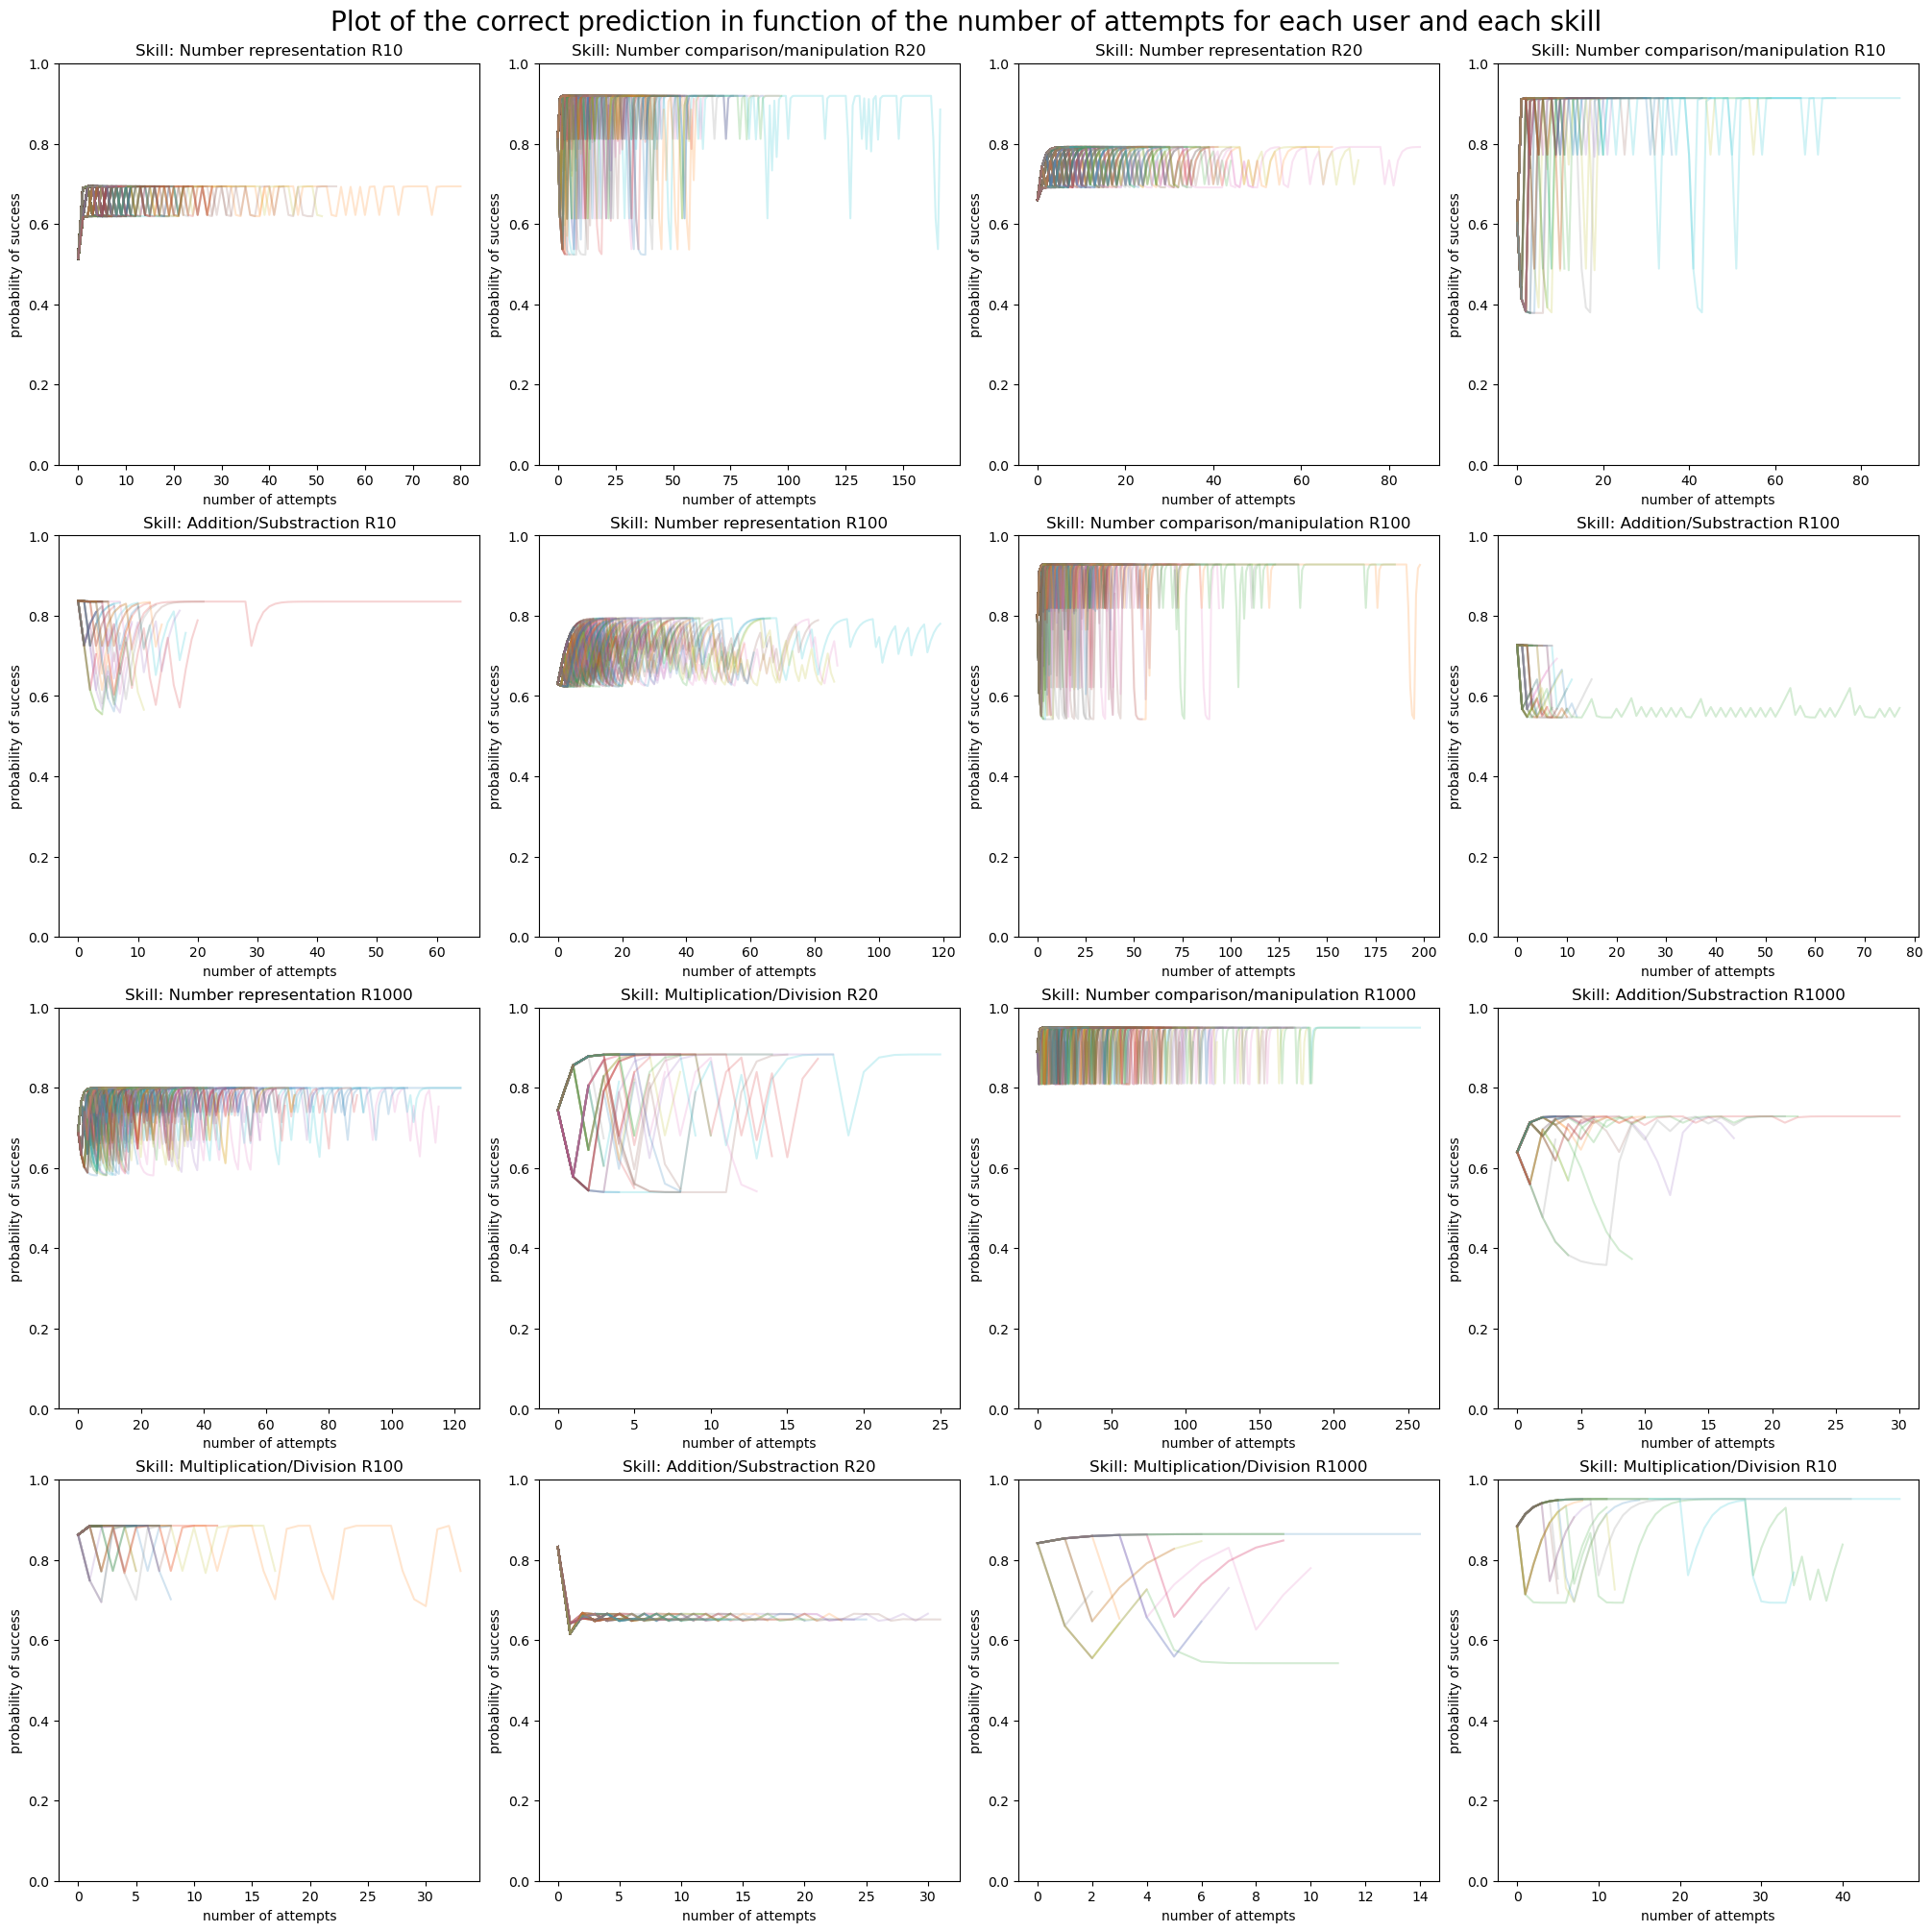

In [233]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20), constrained_layout=True)
for skill, axe in zip(skills, ax.flatten()):
    df = proba_dataset[skill].set_index('attempt', inplace=False)
    df.groupby('user_id')['correct_predictions'].plot(alpha=0.2, ax=axe, legend=False)
    axe.set_xlabel('number of attempts')
    axe.set_ylabel('probability of success')
    axe.set_title('Skill: {}'.format(skill))
    axe.set_ylim(0, 1)
plt.suptitle('Plot of the correct prediction in function of the number of attempts for each user and each skill', fontsize=20)
plt.show()

# Fit the exponential function

In [234]:
def exp_model(x, a, b, lambda_):
    return a - b*np.exp(-lambda_*x)

def exp_fit(x):
    param_pred, _ = scipy.optimize.curve_fit(lambda t,a,b,lambda_: a-b*np.exp(-lambda_*t),  x.attempt,  x.correct_predictions, bounds=([0,-1,0], [1, 1, np.inf]))
    a, b, lambda_ = param_pred
    return pd.Series([a, b, lambda_], index=['a', 'b', 'lambda_'])

In [290]:
# Compute the parameters for the exponential fit for each student
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    students_param = {}
    for skill in skills:
        students_param[skill] = proba_dataset[skill].groupby('user_id').apply(lambda x: exp_fit(x))
        students_param[skill]['number_attempts'] = proba_dataset[skill].groupby('user_id').size()

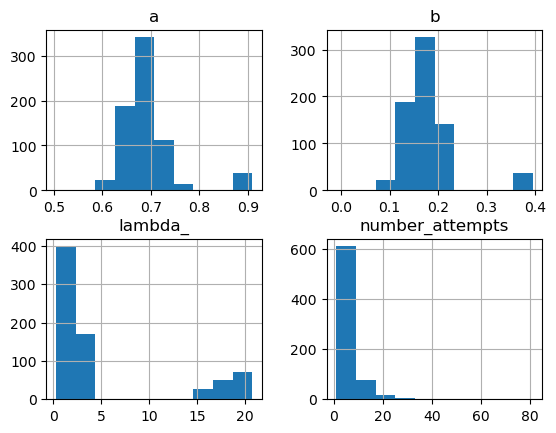

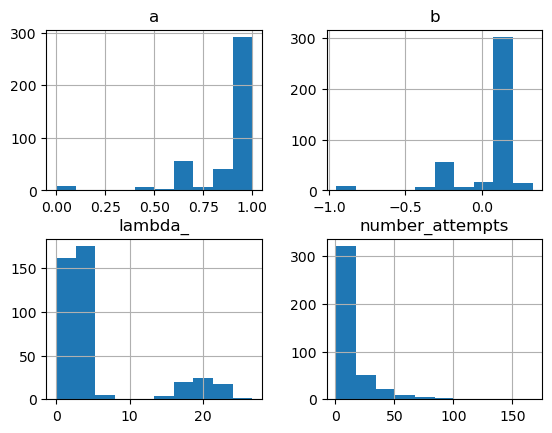

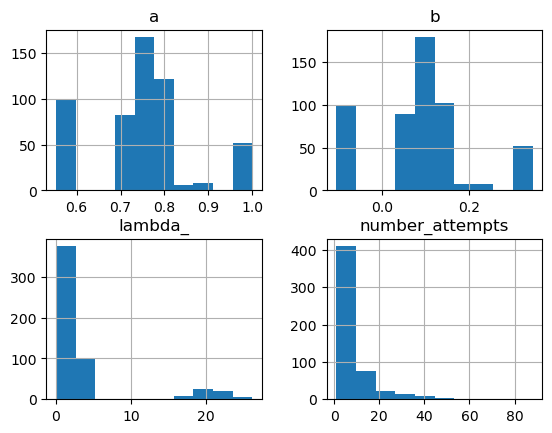

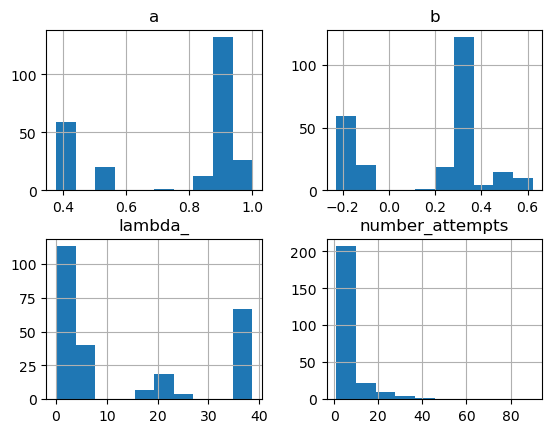

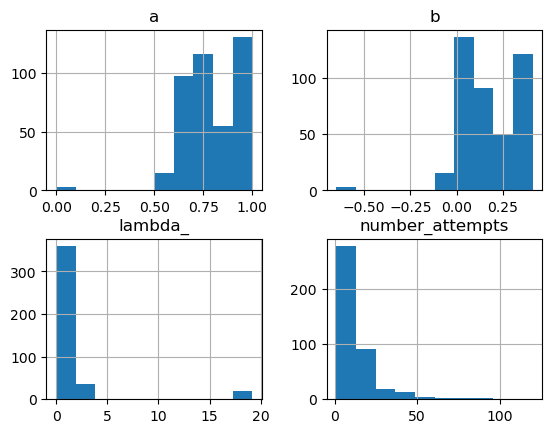

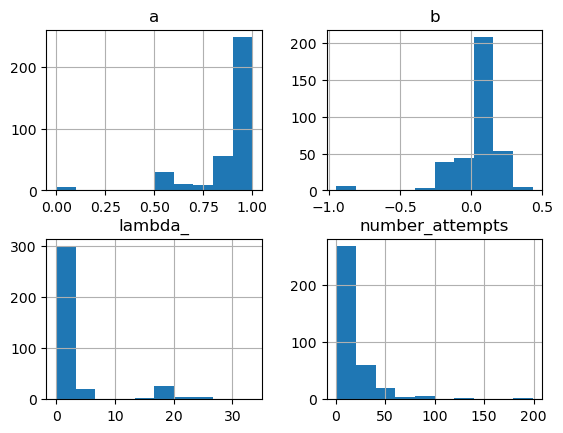

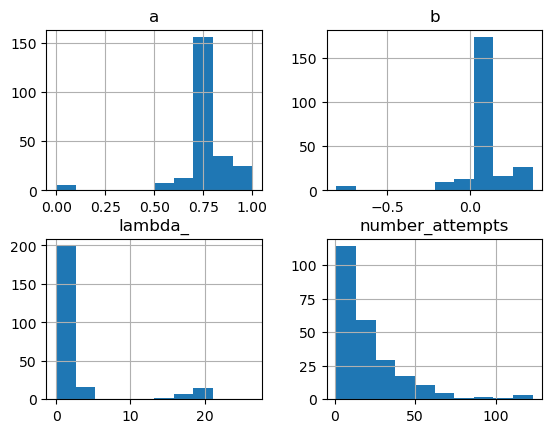

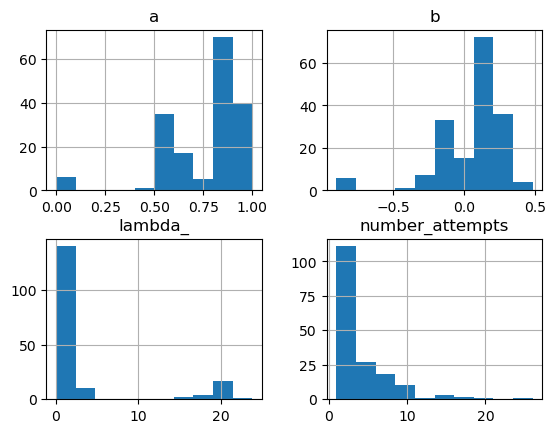

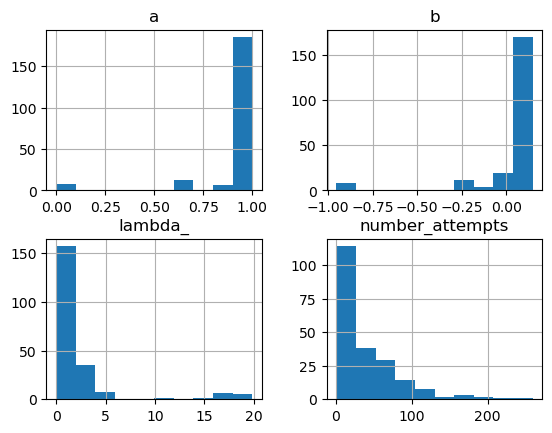

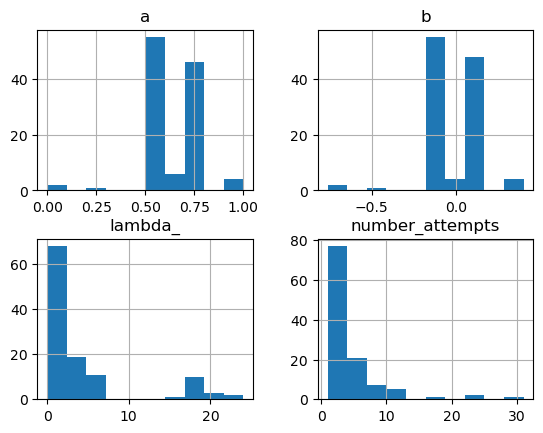

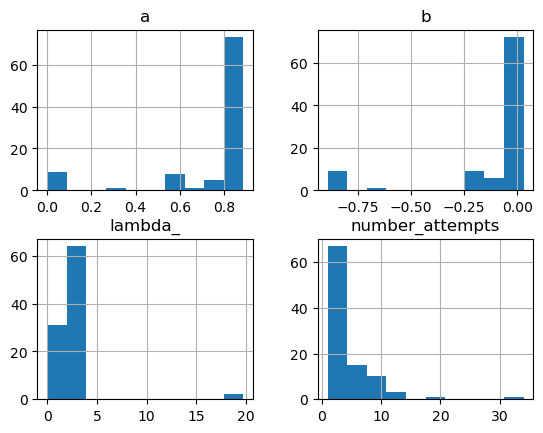

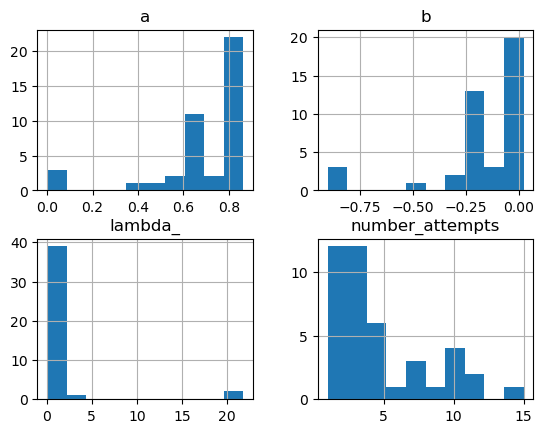

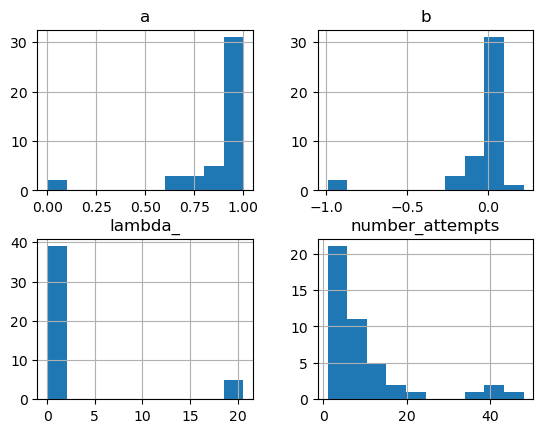

In [295]:
# Histogram and descriptive statistics of the parameters for each skill
"""for skill in skills :
    print(skill)
    pd.DataFrame(students_param[skill]).hist()
    display(pd.DataFrame(students_param[skill]).describe())"""

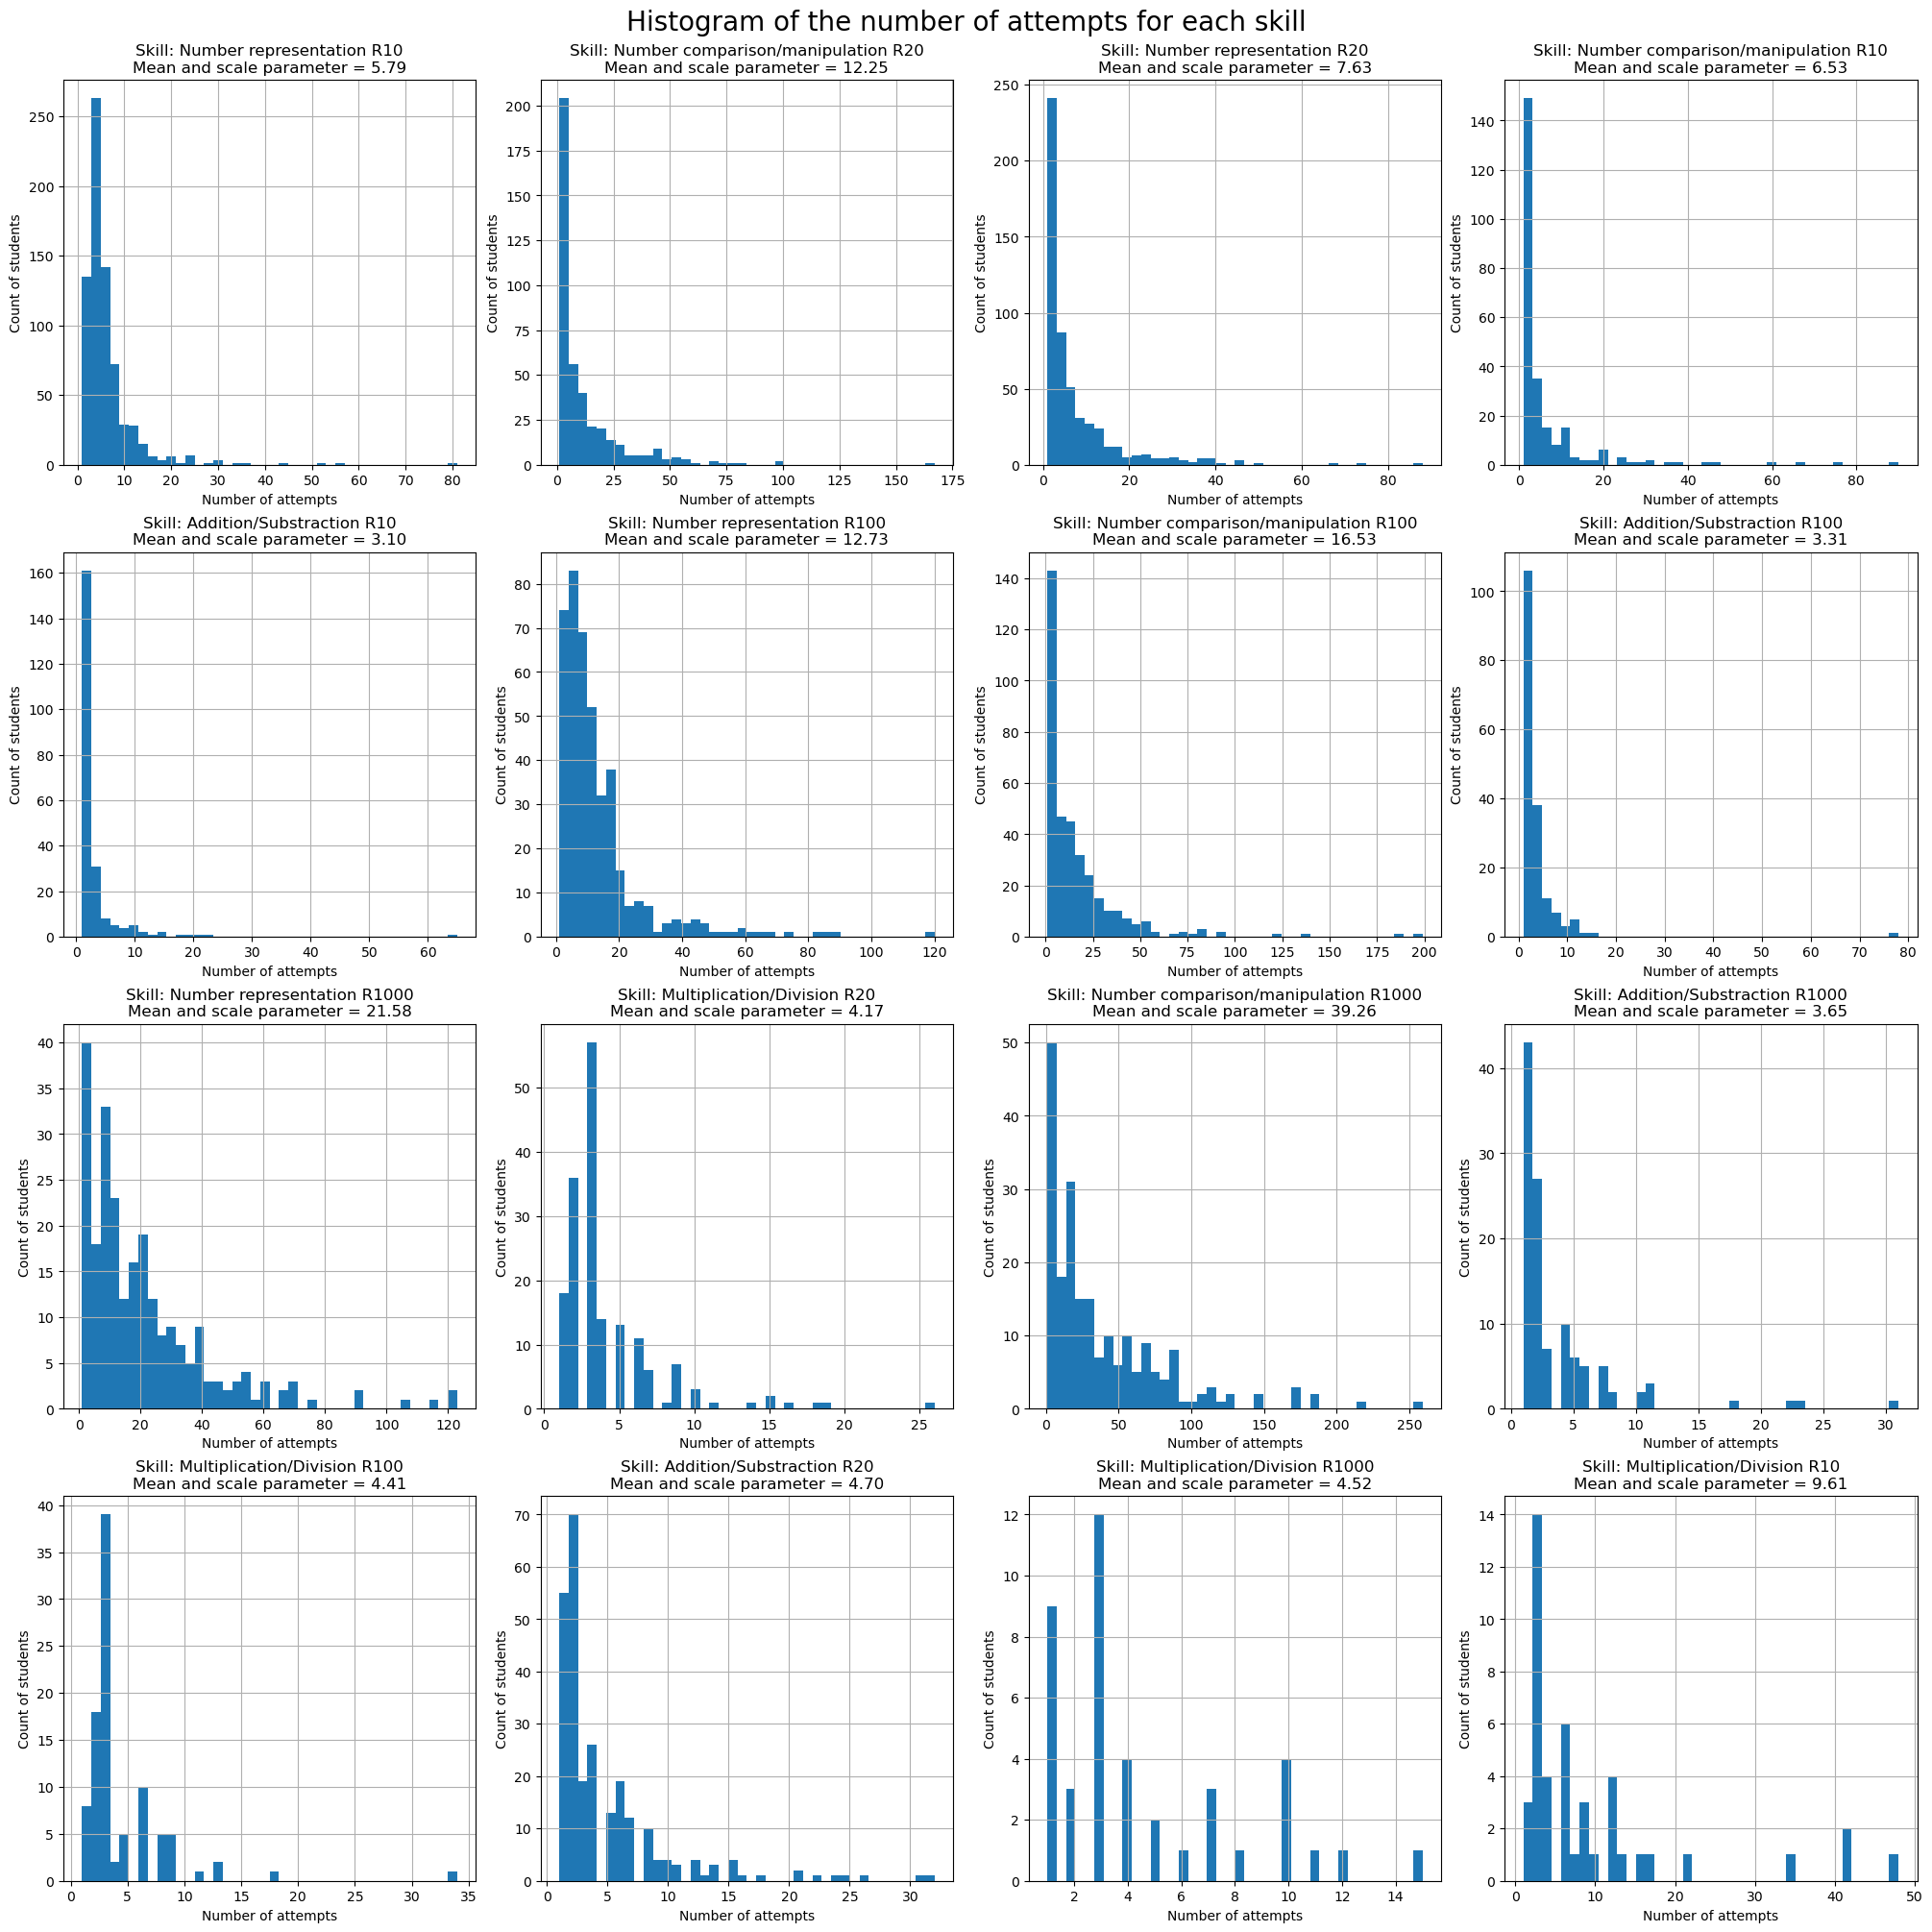

In [236]:
# Plot the histogram of the number of attempts
scale_param = {}
fig, ax = plt.subplots(4, 4, figsize=(4*5, 4*5), constrained_layout=True)
for skill, axe in zip(skills, ax.flatten()):
    scale_param[skill] = students_param[skill].number_attempts.mean()
    students_param[skill].number_attempts.hist(bins=40, ax=axe)
    axe.set_title('Skill: {}\nMean and scale parameter = {:.2f}'.format(skill, scale_param[skill]))
    axe.set_xlabel('Number of attempts')
    axe.set_ylabel('Count of students')
plt.suptitle('Histogram of the number of attempts for each skill', fontsize=20)
plt.show()

For the skill Number representation R10 there is 105 students with more than 8 attempts which corresponds to 14.64 % of the students


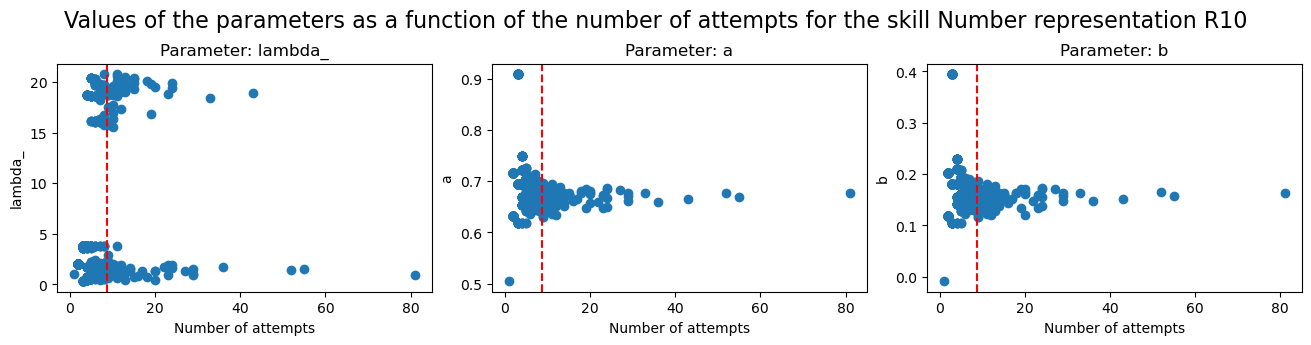

For the skill Number comparison/manipulation R20 there is 81 students with more than 18 attempts which corresponds to 19.8 % of the students


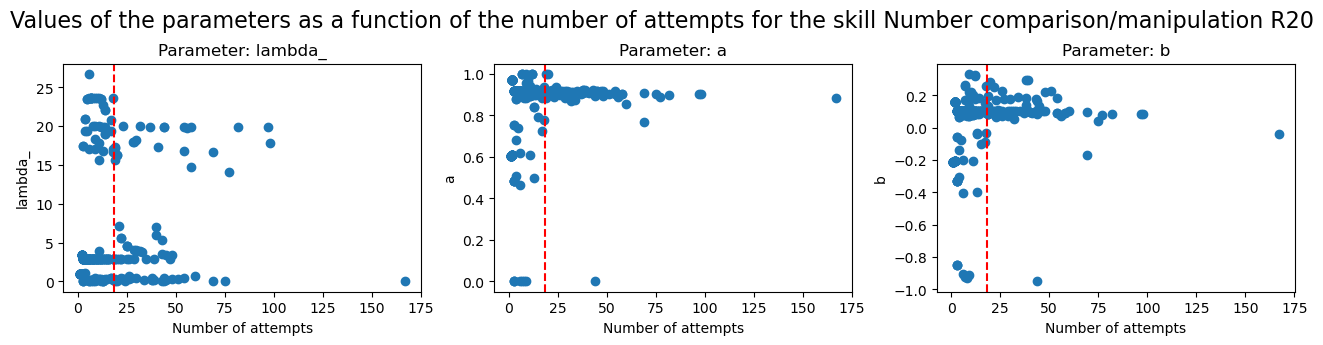

For the skill Number representation R20 there is 100 students with more than 11 attempts which corresponds to 18.62 % of the students


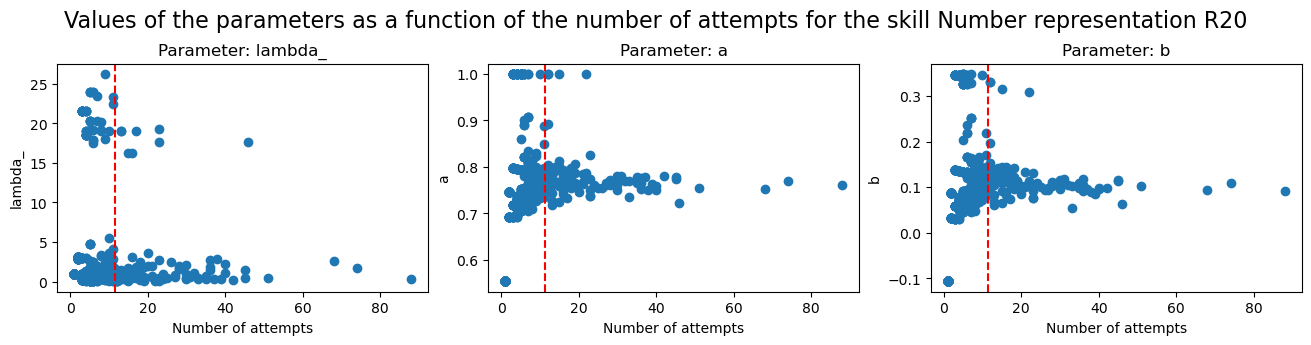

For the skill Number comparison/manipulation R10 there is 43 students with more than 9 attempts which corresponds to 17.2 % of the students


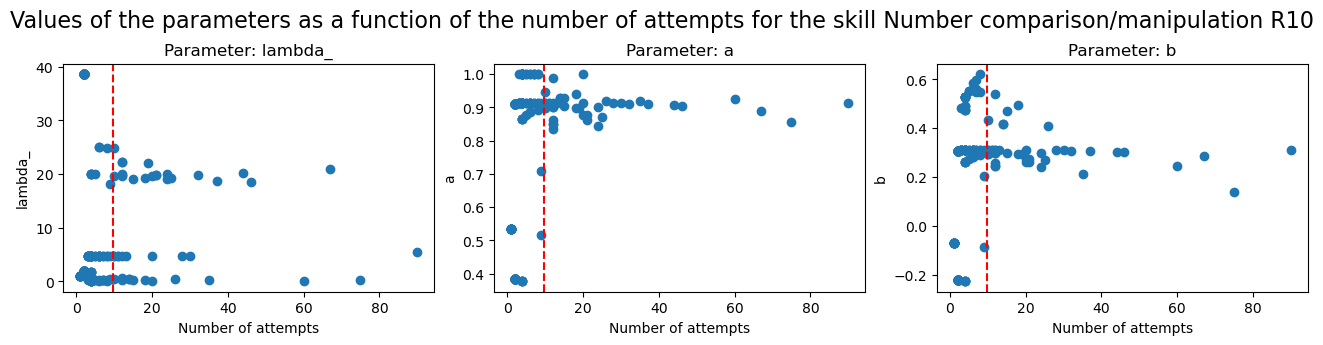

For the skill Addition/Substraction R10 there is 32 students with more than 4 attempts which corresponds to 14.29 % of the students


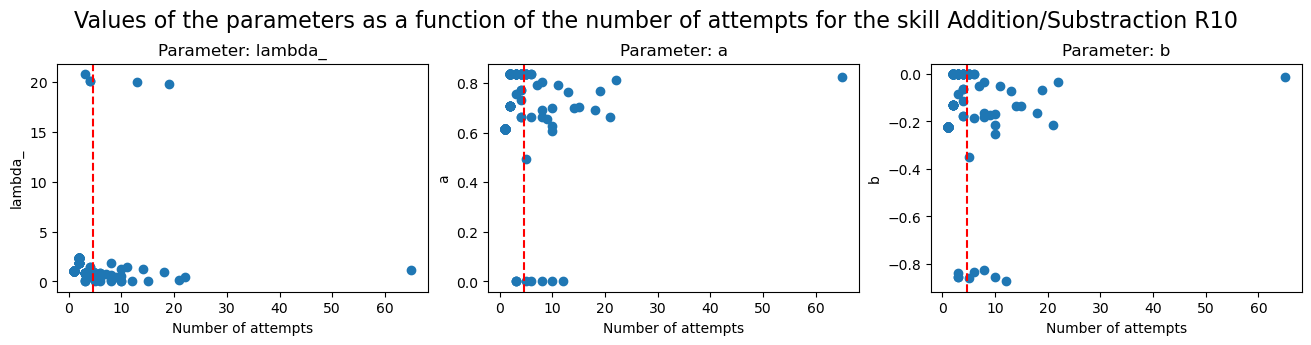

For the skill Number representation R100 there is 59 students with more than 19 attempts which corresponds to 14.18 % of the students


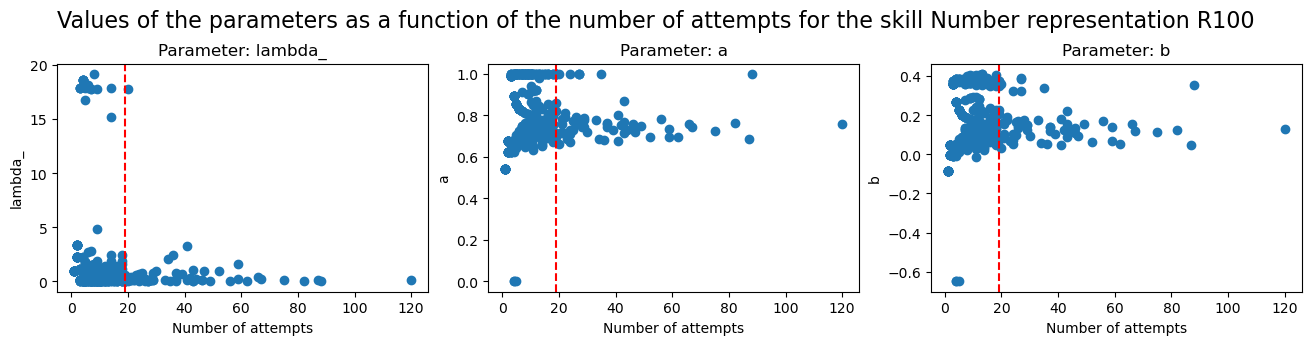

For the skill Number comparison/manipulation R100 there is 69 students with more than 24 attempts which corresponds to 19.22 % of the students


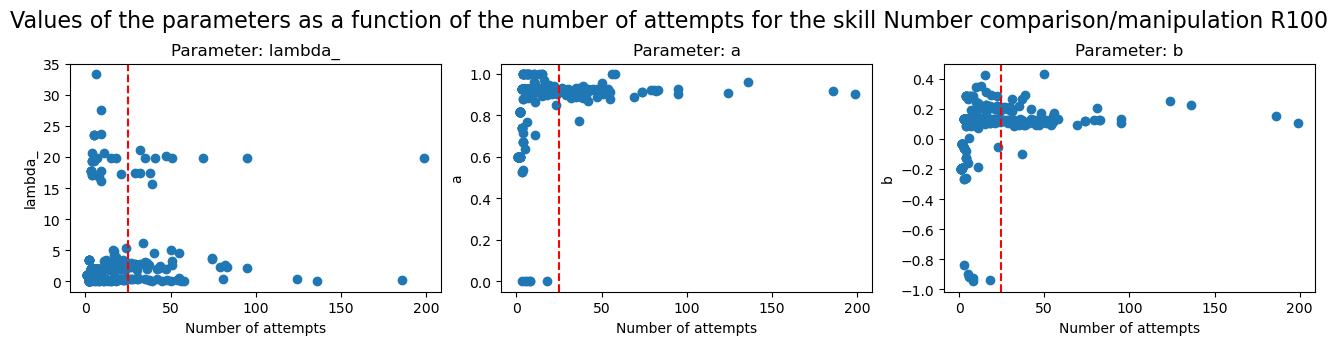

For the skill Addition/Substraction R100 there is 29 students with more than 4 attempts which corresponds to 16.76 % of the students


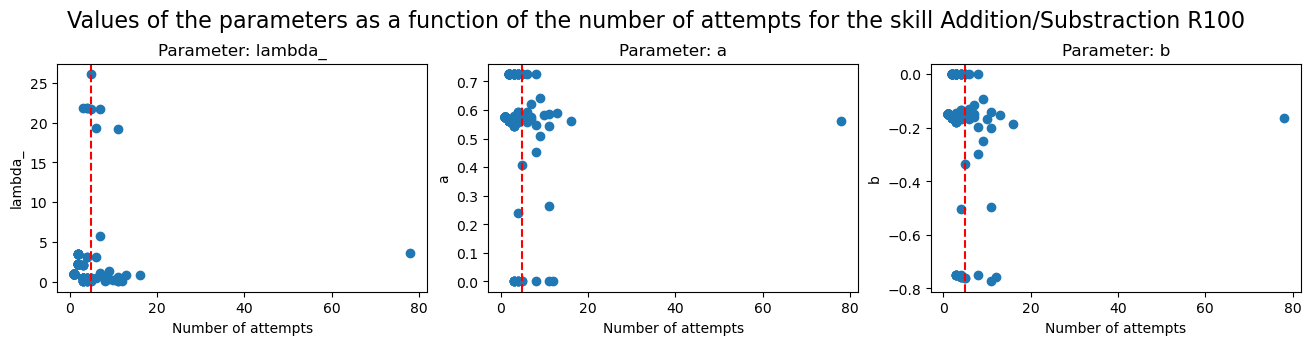

For the skill Number representation R1000 there is 47 students with more than 32 attempts which corresponds to 19.42 % of the students


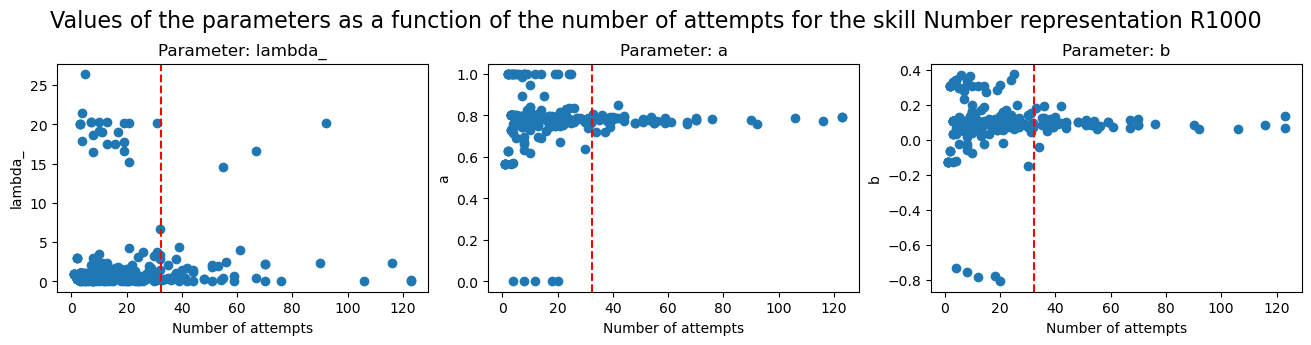

For the skill Multiplication/Division R20 there is 25 students with more than 6 attempts which corresponds to 14.37 % of the students


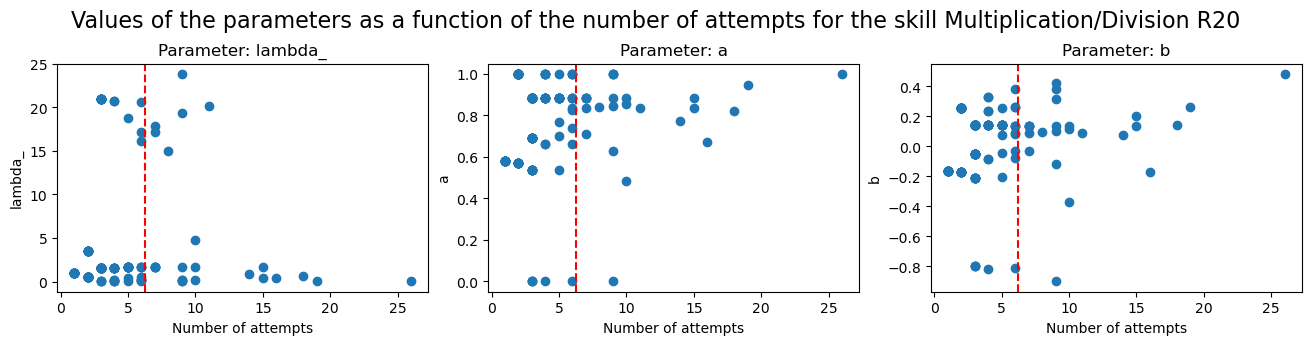

For the skill Number comparison/manipulation R1000 there is 51 students with more than 58 attempts which corresponds to 24.06 % of the students


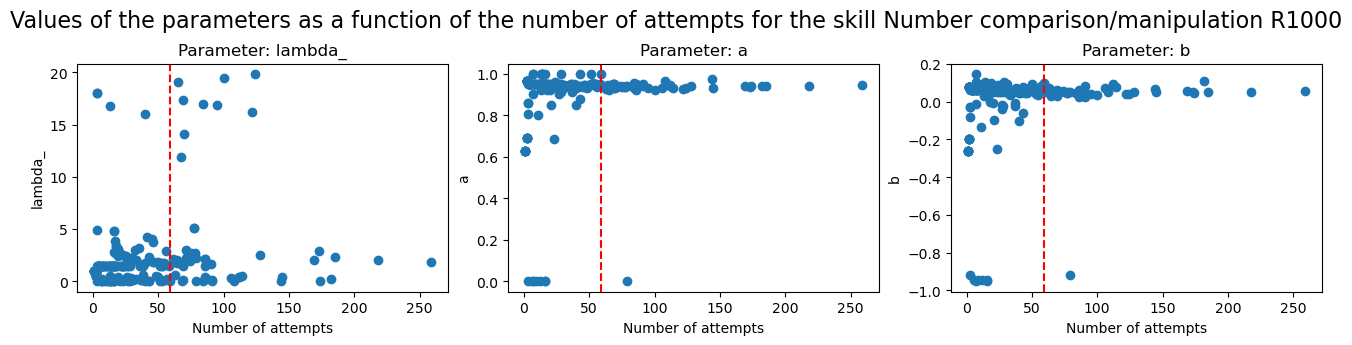

For the skill Addition/Substraction R1000 there is 21 students with more than 5 attempts which corresponds to 18.42 % of the students


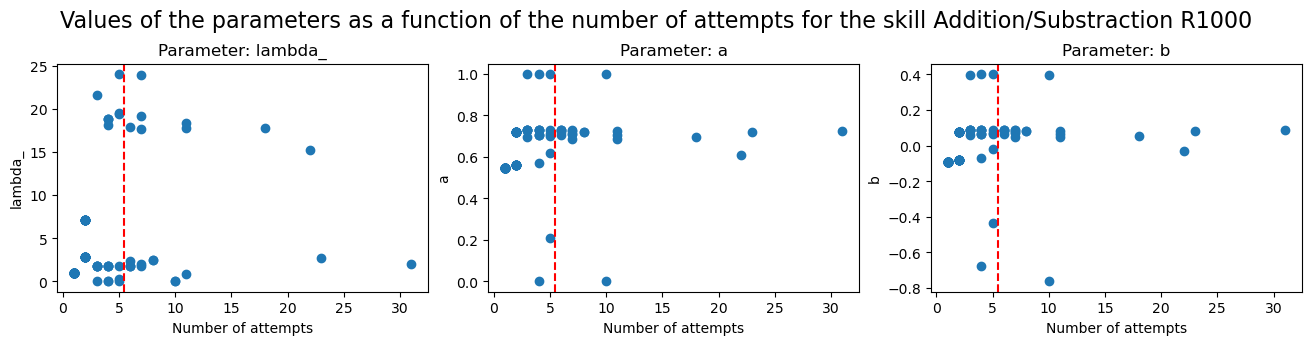

For the skill Multiplication/Division R100 there is 15 students with more than 6 attempts which corresponds to 15.46 % of the students


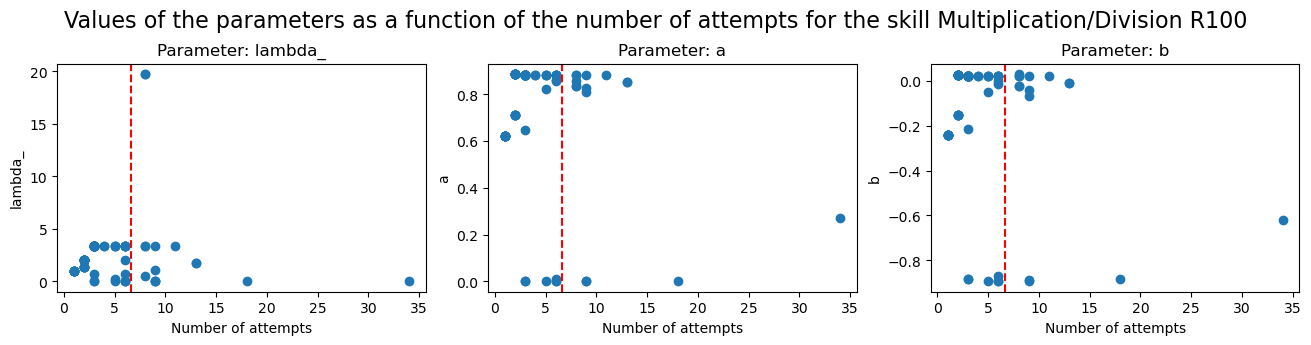

For the skill Addition/Substraction R20 there is 43 students with more than 7 attempts which corresponds to 16.73 % of the students


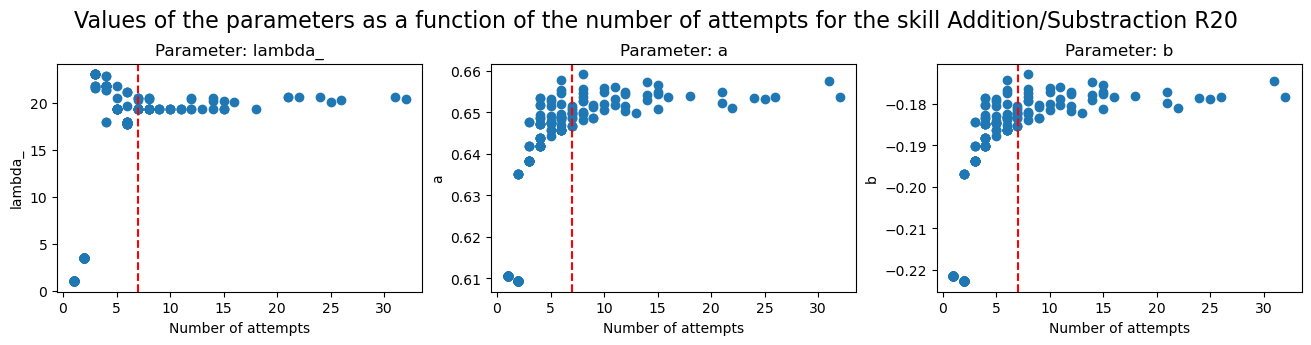

For the skill Multiplication/Division R1000 there is 11 students with more than 6 attempts which corresponds to 26.19 % of the students


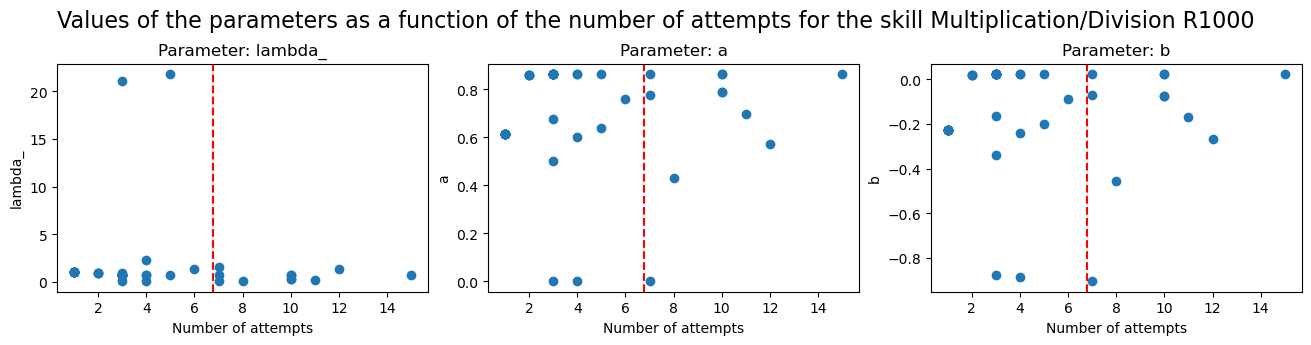

For the skill Multiplication/Division R10 there is 7 students with more than 14 attempts which corresponds to 15.91 % of the students


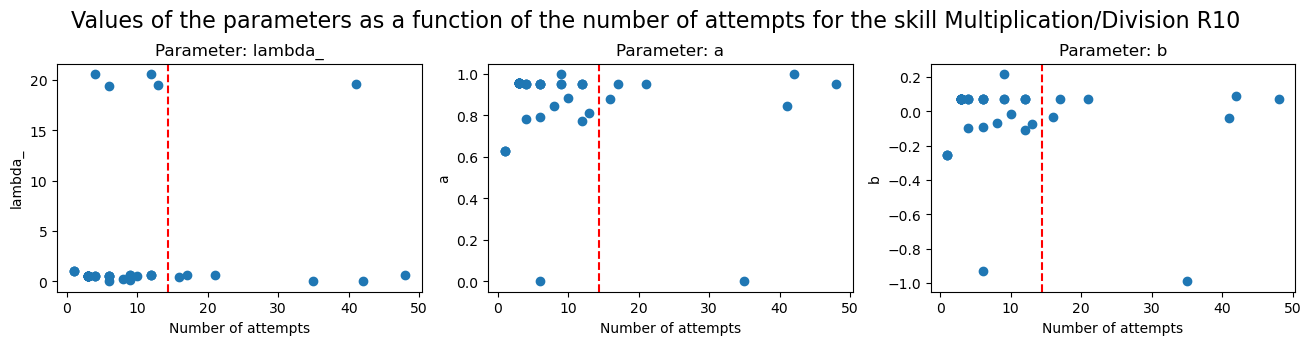

In [237]:
# Plot the values of each parameter as a function of the number of attempts
parameters = ['lambda_', 'a', 'b']
for skill in skills:
    fig, ax = plt.subplots(ncols=3, figsize=(13,3), constrained_layout=True)
    
    # Keep only the students that played the most, i.e. that are more likely to have reached their maximum performance
    min_attempts = scale_param[skill]*1.5
    n_trained_students = students_param[skill][students_param[skill]['number_attempts'] > min_attempts].shape[0]
    print('For the skill', skill, 'there is', n_trained_students, 'students with more than', int(min_attempts), 'attempts which corresponds to', round(n_trained_students/students_param[skill].shape[0]*100, 2), '% of the students')  
    
    for i in range(len(parameters)):
        ax[i].plot(students_param[skill]['number_attempts'], students_param[skill][parameters[i]], 'o')
        ax[i].set_xlabel('Number of attempts')
        ax[i].set_ylabel(parameters[i])
        ax[i].set_title('Parameter: ' + parameters[i])
        ax[i].axvline(x=min_attempts, color='r', linestyle='--', label='Only students with more than ' + str(int(min_attempts)) + ' attempts are kept')
    plt.suptitle('Values of the parameters as a function of the number of attempts for the skill ' + skill, y=1.1, fontsize=16)
    plt.show()

In [238]:
# Extract the median value of each parameter for each skill
median_param = {}
for skill in skills:
    median_param[skill] = master_param[skill][parameters].median()
    
print('The median values of the parameters are:')
median_param = pd.DataFrame(median_param)
display(median_param)

The median values of the parameters are:


,Number representation R10,Number comparison/manipulation R20,Number representation R20,Number comparison/manipulation R10,Addition/Substraction R10,Number representation R100,Number comparison/manipulation R100,Addition/Substraction R100,Number representation R1000,Multiplication/Division R20,Number comparison/manipulation R1000,Addition/Substraction R1000,Multiplication/Division R100,Addition/Substraction R20,Multiplication/Division R1000,Multiplication/Division R10
lambda_,1.95570,0.69074,0.39452,3.37996,1.12928,0.20610,2.40410,2.51842,0.21129,2.05288,2.77059,1.61149,1.16131,2.03072,0.60473,3.06359
a,0.66380,0.92269,0.78535,0.91054,0.75858,0.72602,0.91814,0.59865,0.80297,0.88537,0.94316,0.72050,0.87873,0.64016,0.87348,0.93345
b,0.12651,0.08260,0.10547,0.29382,-0.08075,0.06385,0.12315,-0.16446,0.11863,0.15024,0.05500,0.08577,0.03052,-0.19046,0.06882,0.04083


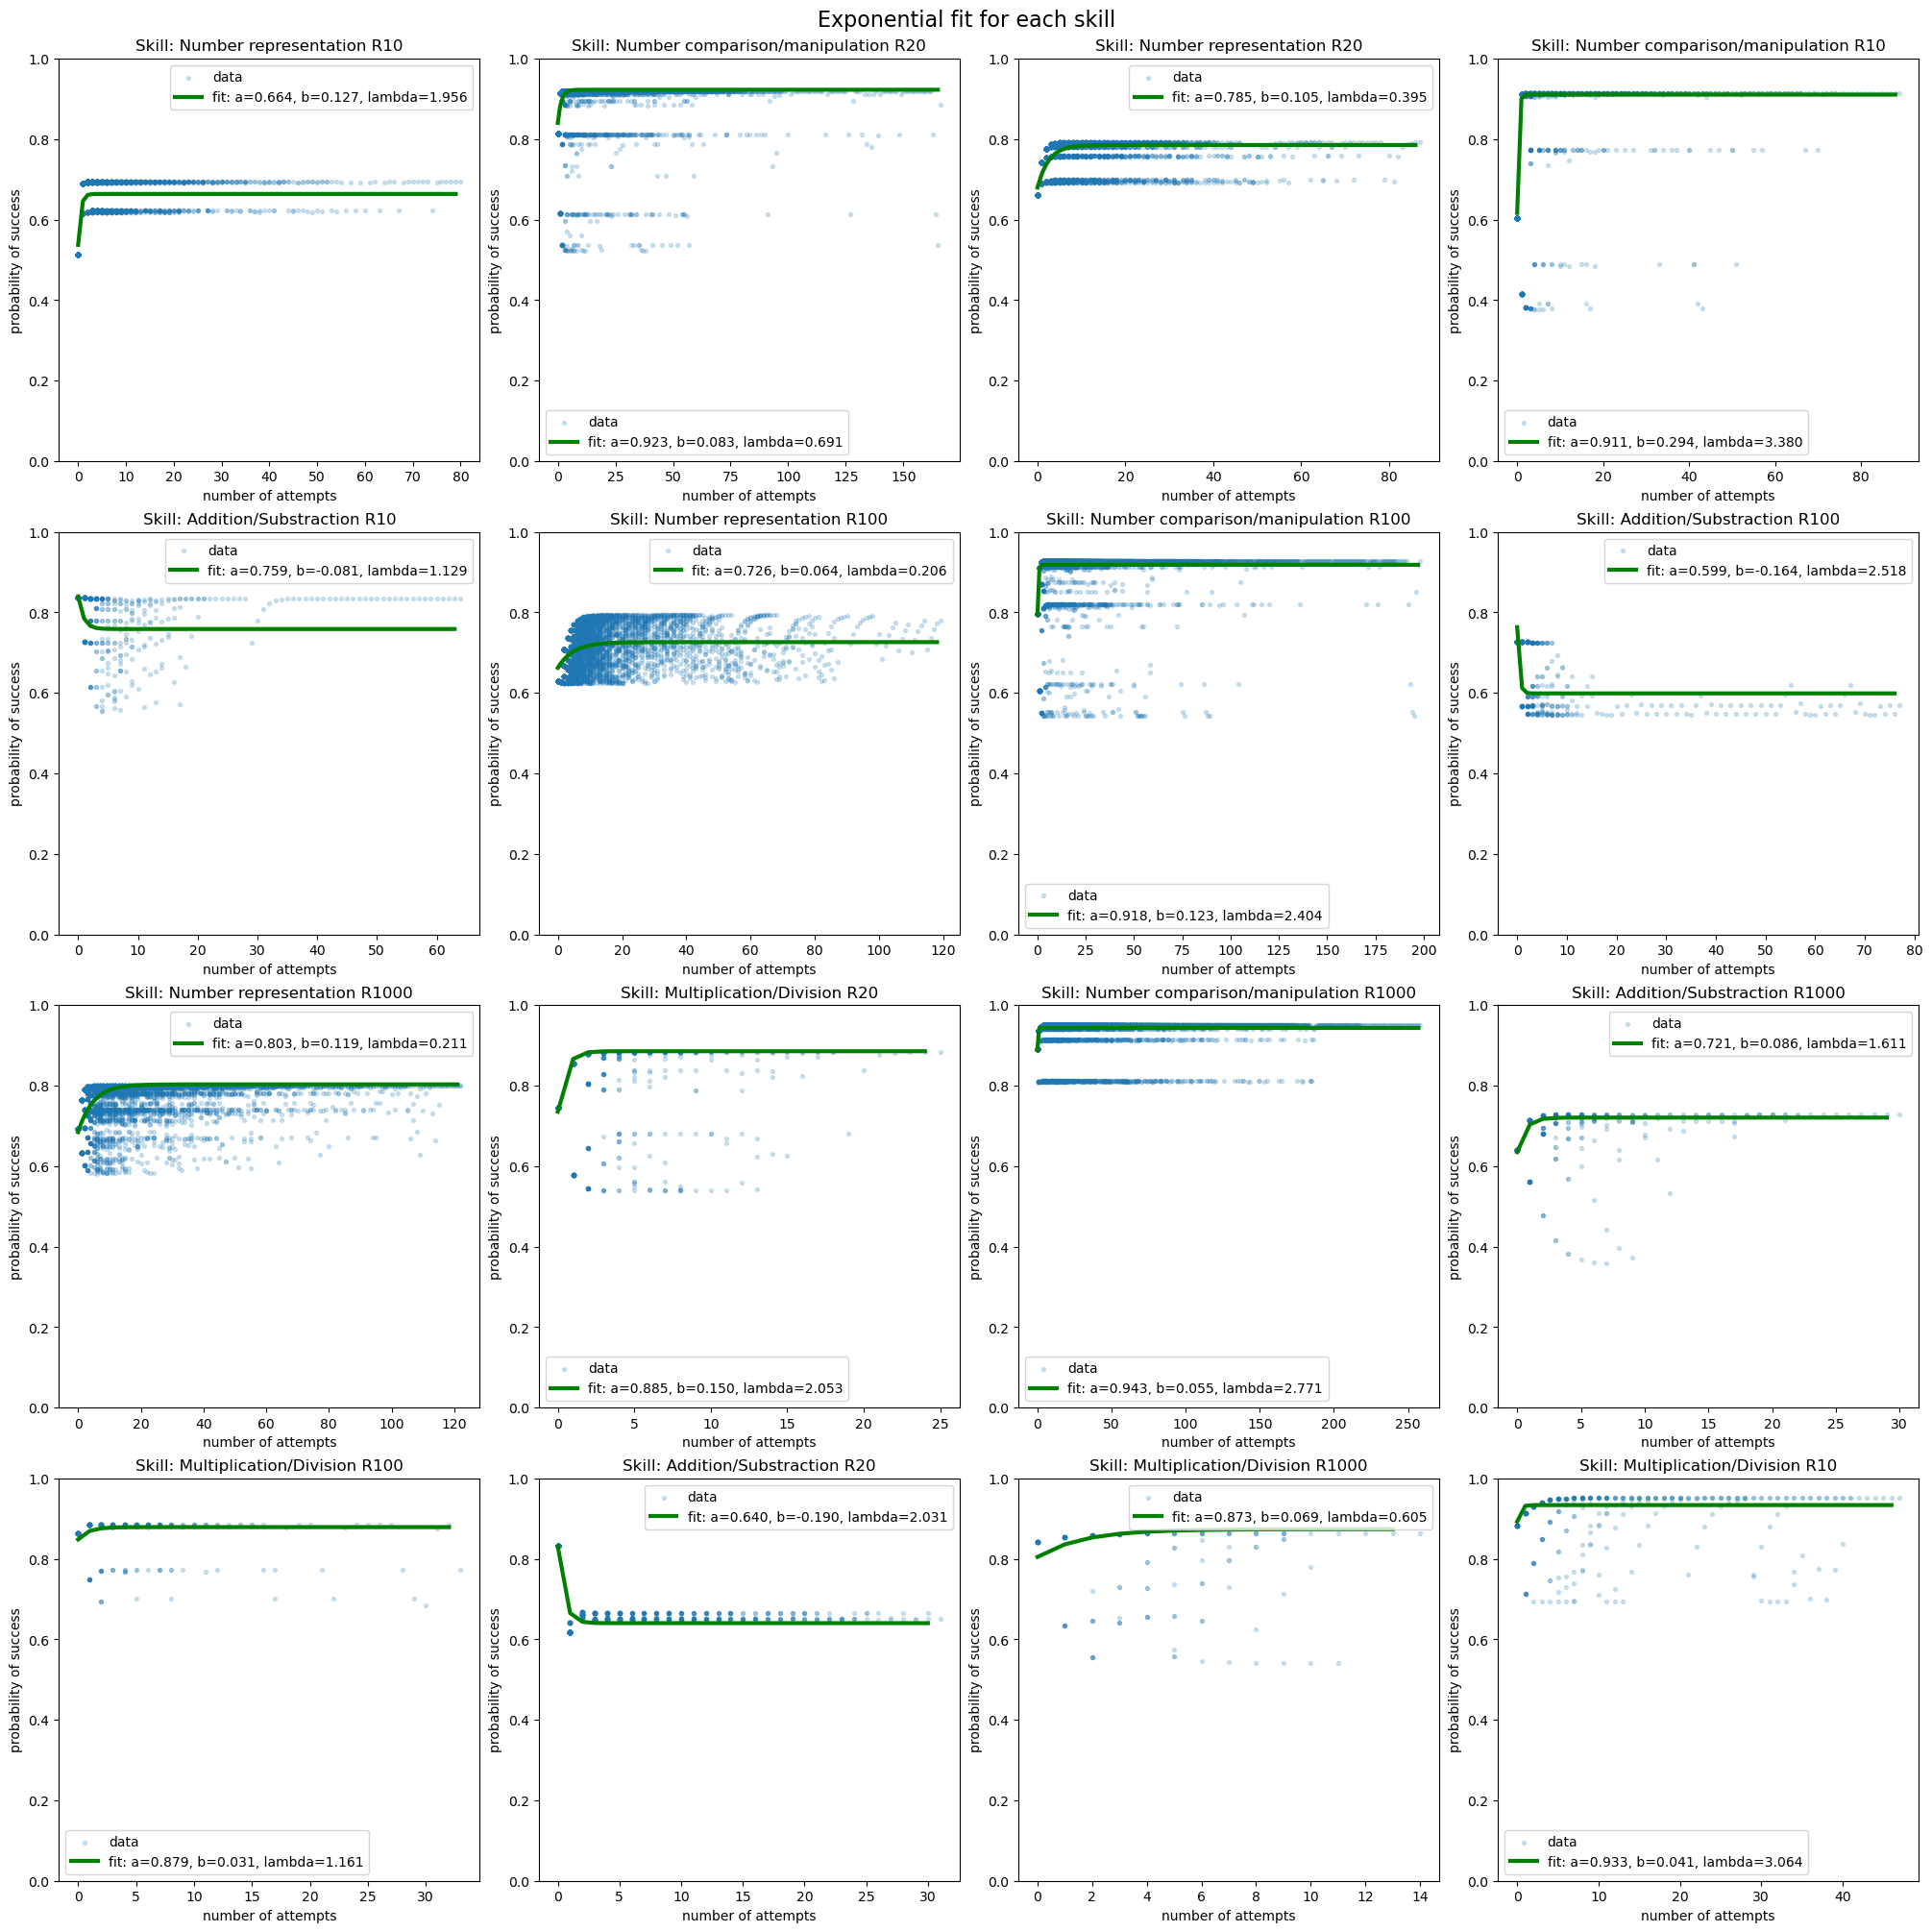

In [239]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20), constrained_layout=True)
for skill, axe in zip(skills, ax.flatten()):
    rx = np.arange(max(proba_dataset[skill].attempt))
    a_pred, b_pred, lambda_pred = median_param[skill].a, median_param[skill].b, median_param[skill].lambda_
    
    axe.scatter(proba_dataset[skill].attempt, proba_dataset[skill].correct_predictions, label='data', alpha=0.2, s=8)
    axe.plot(rx, exp_model(rx, a_pred, b_pred, lambda_pred), label='fit: a=%5.3f, b=%5.3f, lambda=%5.3f' % tuple([a_pred, b_pred, lambda_pred]), color='green', linewidth=3)
    axe.set_xlabel('number of attempts')
    axe.set_ylabel('probability of success')
    axe.set_title('Skill: {}'.format(skill))
    axe.set_ylim(0, 1)
    axe.legend()
plt.suptitle('Exponential fit for each skill', fontsize=16)
plt.show()

# Selection of the relevant skills
Certain skills present a decreasing fit of the exponential function, however we can only predict the number of remaining attempt if the students are indeed learning over training sessions. We will therefore only consider skills with a positive slope (i.e. with the parameter $b > 0$).
Moreover, there are some skills that were trained only by a few students or for a few number of attempts, which makes the exponential fit unreliable. We will therefore only consider skills that were trained for at least X attempts by at least X students.

In [240]:
removed_skills = subtasks['skill_name'].unique()
# Remove the skills with a negative b parameter
skills = [skill for skill in subtasks['skill_name'].unique() if median_param[skill].b > 0]

# Remove the skills with not enough data
"""min_attempts = 5
min_students = 25
skills = [skill for skill in skills if 
          students_param[skill][students_param[skill]['number_attempts'] 
                                > min_attempts].shape[0] 
          > min_students] """
removed_skills = [skill for skill in removed_skills if skill not in skills]
print('The skills that are removed are:', *removed_skills, sep=', ')

The skills that are removed are:, Addition/Substraction R10, Addition/Substraction R100, Addition/Substraction R20


# Predict the number of attempt

In [241]:
# Define which probability of success is considered as mastered
print('We consider that a student has mastered the skill if the probability of success is higher than 95.5% of the maximum probability of success')
print('Here we display the probability of success considered as mastered for each skill, as well as the expected number of attempts to reach this probability of success, for a student that has not begun to learn the skill yet : ')
mastering = {'proba': {}, 'tot_attempt': {}}
for skill in skills:
    a_pred, b_pred, lambda_pred = median_param[skill].a, median_param[skill].b, median_param[skill].lambda_
    mastering['proba'][skill] = 0.99*a_pred
    mastering['tot_attempt'][skill] = np.ceil((-1/lambda_pred)*np.log((a_pred - mastering['proba'][skill])/b_pred)).astype(int)
display(pd.DataFrame(mastering))

We consider that a student has mastered the skill if the probability of success is higher than 95.5% of the maximum probability of success
Here we display the probability of success considered as mastered for each skill, as well as the expected number of attempts to reach this probability of success, for a student that has not begun to learn the skill yet : 


,proba,tot_attempt
Number representation R10,0.65716,2
Number comparison/manipulation R20,0.91346,4
Number representation R20,0.77750,7
Number comparison/manipulation R10,0.90144,2
Number representation R100,0.71876,11
Number comparison/manipulation R100,0.90896,2
Number representation R1000,0.79494,13
Multiplication/Division R20,0.87652,2
Number comparison/manipulation R1000,0.93372,1
Addition/Substraction R1000,0.71330,2


In [242]:
def attempt_from_proba(proba, a_pred, b_pred, lambda_pred, confidence = 0.99):
    proba_mastering = confidence*a_pred
    if proba > proba_mastering:
        return 0
    else:
        tot_attempt = np.ceil((-1/lambda_pred)*np.log((a_pred - proba_mastering)/b_pred)).astype(int)
        equivalent_attempt = np.ceil((-1/lambda_pred)*np.log((a_pred - proba)/b_pred)).astype(int)
        return tot_attempt - equivalent_attempt

To test our model and predict the number of attempts needed to master a skill, we will use the data of the test set. <br>
To do so, we (theoretically) only need the probability prediction for the last attempt (which summarise all the data we have for a student until now). <br>
However, as we want to compare our predictions with the real number of attempts, we will use a previous attempt as 'fake' last attempt and predict the number of attempts needed to master the skill from this fake last attempt.

In [261]:
test_dataset = {}
for skill in skills:    
    # Extract the correct prediction for the 3rd attempt for each student (if it exists)
    third_proba = proba_test[skill][proba_test[skill]['attempt'] == 3].rename(columns={'correct_predictions': 'third_proba'}).drop(columns=['attempt'])

    # Extract the first attempt number from which the student has actually mastered the skill (this is done by computing a moving average on the correct predictions beforehand)
    mastering_attempt = proba_test[skill].groupby('user_id').rolling(1, on='attempt', min_periods=1)['correct_predictions'].mean().reset_index()
    mastering_attempt = (mastering_attempt[mastering_attempt['correct_predictions'] >= mastering['proba'][skill]]).groupby('user_id')['attempt'].first().rename('true_attempts')
    
    # Merge de 2 dataframes and keep only the students that have both a 3rd attempt and a mastered the skill
    test_dataset[skill] = pd.merge(third_proba, mastering_attempt, on='user_id', how='inner')
    
test_dataset['Number representation R100']

,user_id,third_proba,true_attempts
0,15,0.65832,10
1,33,0.73590,3
2,36,0.73590,3
3,68,0.70357,6
4,84,0.65832,7
...,...,...,...
60,957,0.73590,3
61,961,0.66519,5
62,986,0.68106,10
63,988,0.73590,3


In [262]:
# Predict the number of attempts needed to master the skill
for skill in skills:
    a_pred, b_pred, lambda_pred = median_param[skill].a, median_param[skill].b, median_param[skill].lambda_
    test_dataset[skill]['predicted_attempts'] = test_dataset[skill].third_proba.apply(lambda x: attempt_from_proba(x, a_pred, b_pred, lambda_pred))
print(mastering['proba']['Number representation R100'])
test_dataset['Number representation R100']


0.7187620732252922


,user_id,third_proba,true_attempts,predicted_attempts
0,15,0.65832,10,11
1,33,0.73590,3,0
2,36,0.73590,3,0
3,68,0.70357,6,5
4,84,0.65832,7,11
...,...,...,...,...
60,957,0.73590,3,0
61,961,0.66519,5,10
62,986,0.68106,10,9
63,988,0.73590,3,0


# Evaluate the model

In [263]:
describe_df = pd.DataFrame()
for skill in skills:
    describe_df[skill + ' true'] = test_dataset[skill].true_attempts.describe()
    describe_df[skill + ' predicted'] = test_dataset[skill].predicted_attempts.describe()
display(describe_df)


,Number representation R10 true,Number representation R10 predicted,Number comparison/manipulation R20 true,Number comparison/manipulation R20 predicted,Number representation R20 true,Number representation R20 predicted,Number comparison/manipulation R10 true,Number comparison/manipulation R10 predicted,Number representation R100 true,Number representation R100 predicted,...,Number comparison/manipulation R1000 true,Number comparison/manipulation R1000 predicted,Addition/Substraction R1000 true,Addition/Substraction R1000 predicted,Multiplication/Division R100 true,Multiplication/Division R100 predicted,Multiplication/Division R1000 true,Multiplication/Division R1000 predicted,Multiplication/Division R10 true,Multiplication/Division R10 predicted
count,122.00000,122.00000,72.00000,72.00000,66.00000,66.00000,22.00000,22.00000,65.00000,65.00000,...,41.00000,41.00000,9.00000,9.00000,8.00000,8.00000,0.00000,0.00000,5.00000,5.00000
mean,1.78689,0.36066,2.48611,0.59722,3.92424,2.18182,1.27273,0.18182,5.41538,6.33846,...,1.17073,0.07317,2.11111,0.22222,1.00000,0.00000,NaN,NaN,2.00000,0.00000
std,0.87414,0.48217,0.99283,1.25215,1.37349,2.55348,0.63109,0.39477,2.83886,4.95062,...,0.62859,0.26365,1.36423,0.44096,0.00000,0.00000,NaN,NaN,0.00000,0.00000
min,1.00000,0.00000,2.00000,0.00000,3.00000,0.00000,1.00000,0.00000,3.00000,0.00000,...,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,NaN,NaN,2.00000,0.00000
25%,1.00000,0.00000,2.00000,0.00000,3.00000,0.00000,1.00000,0.00000,3.00000,0.00000,...,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,NaN,NaN,2.00000,0.00000
50%,2.00000,0.00000,2.00000,0.00000,3.00000,0.00000,1.00000,0.00000,5.00000,5.00000,...,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,NaN,NaN,2.00000,0.00000
75%,2.00000,1.00000,2.25000,0.00000,4.75000,5.25000,1.00000,0.00000,6.00000,11.00000,...,1.00000,0.00000,3.00000,0.00000,1.00000,0.00000,NaN,NaN,2.00000,0.00000
max,5.00000,1.00000,7.00000,5.00000,11.00000,6.00000,3.00000,1.00000,14.00000,13.00000,...,4.00000,1.00000,4.00000,1.00000,1.00000,0.00000,NaN,NaN,2.00000,0.00000


,Number representation R10,Number comparison/manipulation R20,Number representation R20,Number comparison/manipulation R10,Number representation R100,Number comparison/manipulation R100,Number representation R1000,Multiplication/Division R20,Number comparison/manipulation R1000,Addition/Substraction R1000,Multiplication/Division R100,Multiplication/Division R1000,Multiplication/Division R10
MAE,1.42623,2.16667,2.04545,1.09091,3.16923,1.63636,3.53488,2.62500,1.09756,1.88889,1.00000,NaN,2.00000


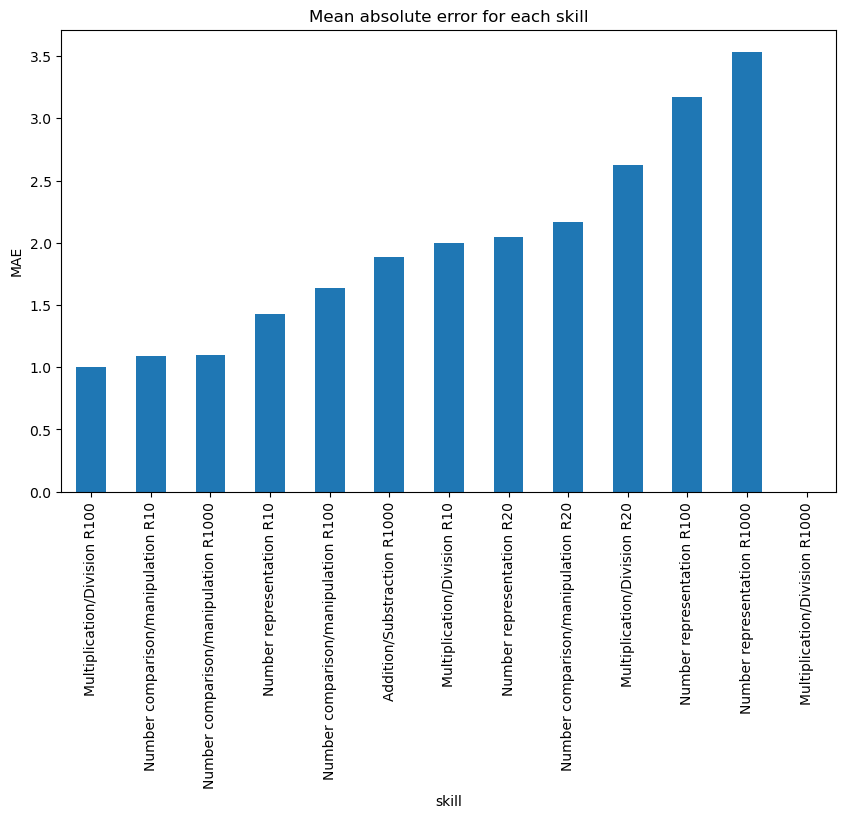

In [282]:
# Compute the RMSE
mae = {}
for skill in skills:
    mae[skill] = np.mean(np.abs(test_dataset[skill].true_attempts - test_dataset[skill].predicted_attempts))
mae = pd.DataFrame(mae, index=['MAE'])
display(mae)

# Sort the skills by MAE
mae = mae.transpose().sort_values(by='MAE')
mae.plot.bar(figsize=(10, 6), title='Mean absolute error for each skill', legend=False, xlabel='skill', ylabel='MAE')

plt.show()

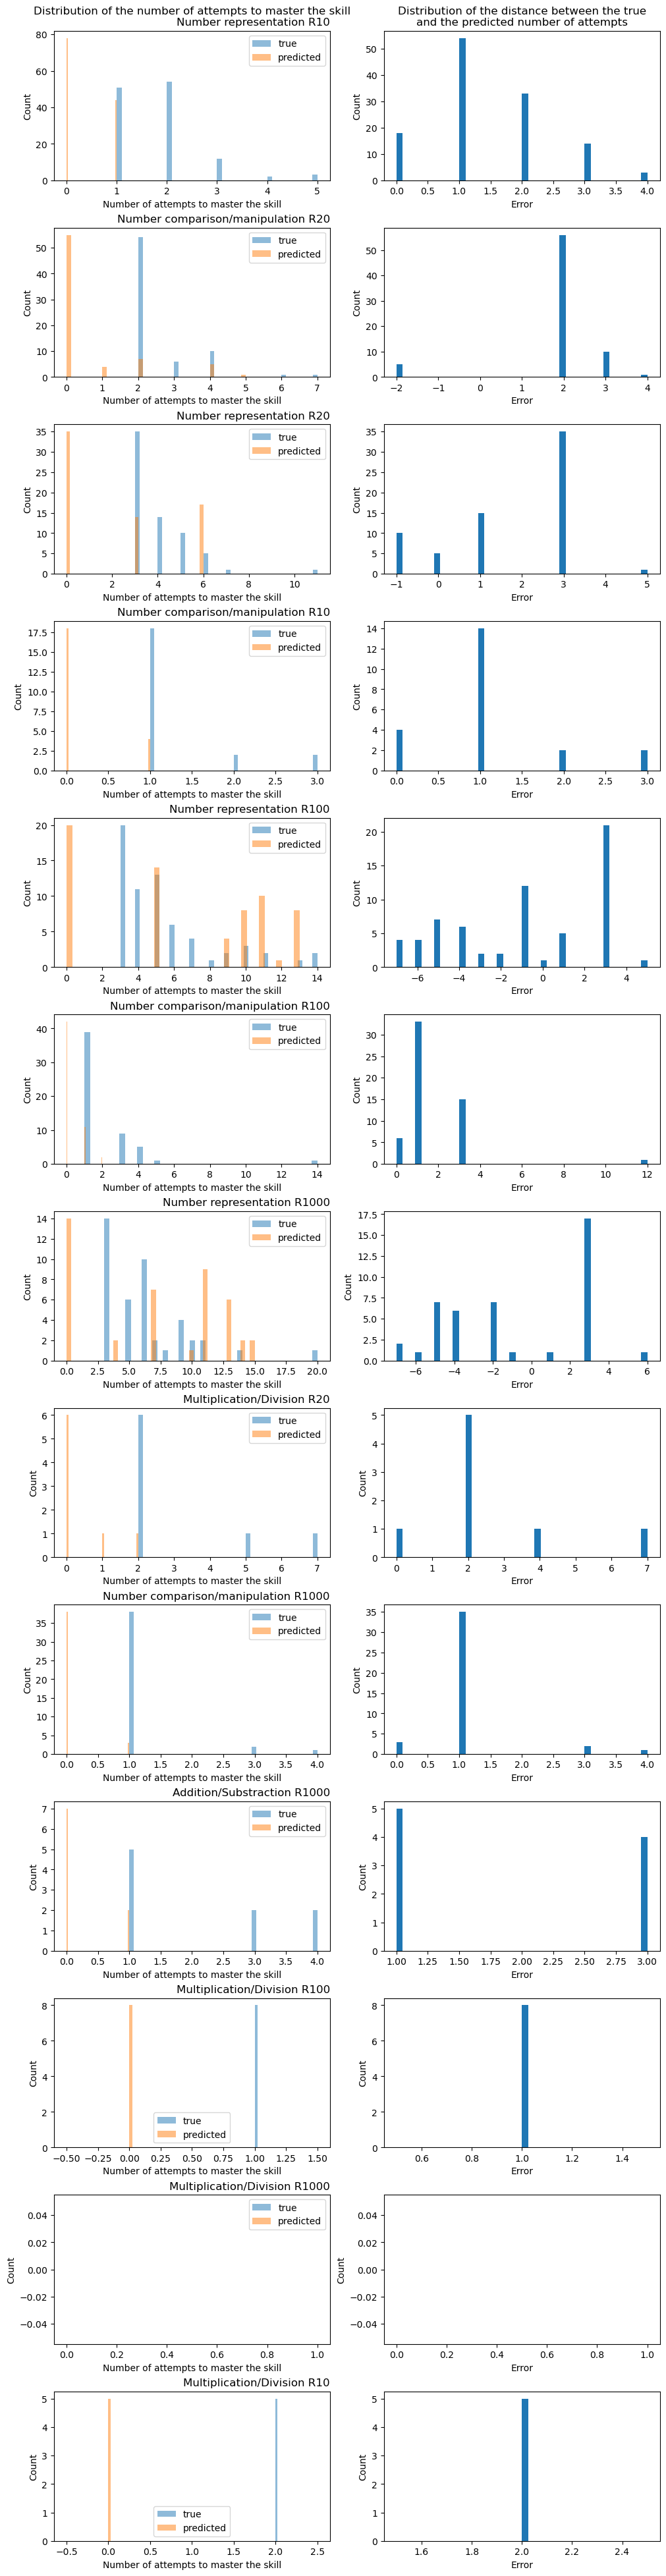

In [288]:
fig, ax = plt.subplots(len(skills), 2, figsize=(10, len(skills)*3), constrained_layout=True)
ax[0][0].set_title('Distribution of the number of attempts to master the skill\n')
ax[0][1].set_title('Distribution of the distance between the true\nand the predicted number of attempts')
# Plot both distributions
for skill in skills:
    ax[skills.index(skill)][0].hist(test_dataset[skill].true_attempts, bins=40, alpha=0.5, label='true')
    ax[skills.index(skill)][0].hist(test_dataset[skill].predicted_attempts, bins=40, alpha=0.5, label='predicted')
    ax[skills.index(skill)][0].set_xlabel('Number of attempts to master the skill')
    ax[skills.index(skill)][0].set_ylabel('Count')
    ax[skills.index(skill)][0].set_title(skill, loc='right')
    ax[skills.index(skill)][0].legend()

    # Plot the distribution of the error
    ax[skills.index(skill)][1].hist(test_dataset[skill].true_attempts - test_dataset[skill].predicted_attempts, bins=40)
    ax[skills.index(skill)][1].set_xlabel('Error')
    ax[skills.index(skill)][1].set_ylabel('Count')
plt.show()